In [2]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import os

In [3]:
os.chdir('/Users/najah/work/internships/meghna/LT05_L1TP_145044_20100428_20161016_01_T1/')

In [134]:
random_points = gpd.read_file('./145044_20100428_roi/145044_20100428_500points.random_points2/145044_20100428_500points.shp')
random_points['class'] = random_points['class'].astype('int')

In [135]:
random_points = random_points.to_crs({'init': 'epsg:4326'})

/Users/najah/miniforge3/envs/ee/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [136]:
random_points['class1'] = random_points['class']

In [138]:
random_points['class'].value_counts()

11    149
5     111
1      56
13     50
4      43
15     35
2      22
16     15
17     10
8       9
Name: class, dtype: int64


### raster readng

In [139]:
l5 = rio.open('./145044_masked_stacked_wgs84.tif')

<AxesSubplot:>

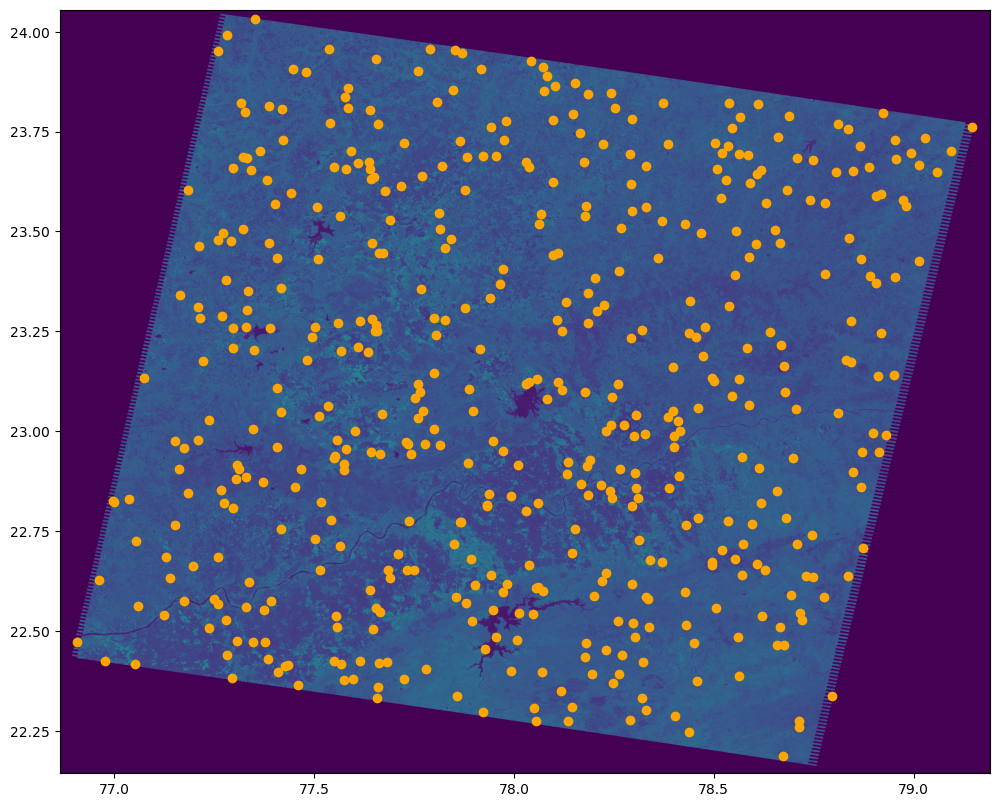

In [140]:
fig, ax = plt.subplots(figsize = (12,12))
random_points.plot(ax = ax, color = 'orange')
show((l5,4), ax = ax)

### Reading bands and extracting values

In [141]:
bands_dict={}
for bands in range(1,7):
    bands_dict[bands]=l5.read(bands)
    #print(bands_dict[bands])
    random_points[f'b{bands}']=0
    
    

In [142]:
for index, row in random_points.iterrows():
    fid = row['id']
    longitude = row['geometry'].x
    latitude = row['geometry'].y
   #repalce it with bands_dict
    #print(b1)
    rowIndex, colIndex = l5.index( longitude, latitude)
    #print(str( b1[rowIndex, colIndex]))
    
    for bands in range(1,7): 
        random_points[f'b{bands}'].loc[index] = bands_dict[bands][rowIndex, colIndex]


/var/folders/_8/2qttjw6x0cvcgsy0js39z68r0000gn/T/ipykernel_50070/3685680889.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_points[f'b{bands}'].loc[index] = bands_dict[bands][rowIndex, colIndex]


In [143]:
# renaming b6 as b7
random_points = random_points.rename(columns = {'b6':'b7'})

### distribution of bands

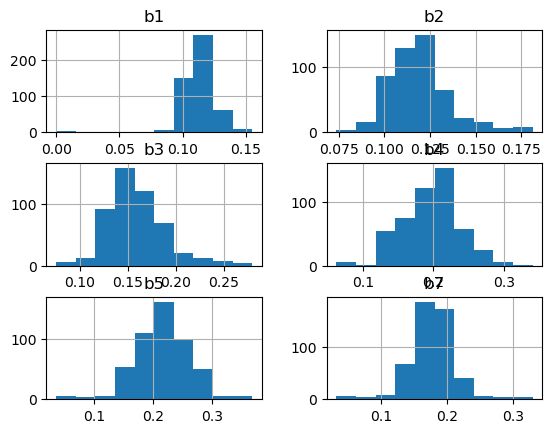

In [88]:
random_points[['b1', 'b2', 'b3', 'b4', 'b5', 'b7']].hist()
plt.show()

In [10]:
###replacing no date with zero
##random_points[['b1', 'b2', 'b3', 'b4', 'b5', 'b7']]

## Indices

In [144]:
import numpy as np

In [145]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [146]:


## normalized differnce fucntion
def normalizedDifference(indice,df,b1,b2):
    df[indice] = (df[b1].astype(float)-df[b2].astype(float))/(df[b1]+df[b2])  
    print( indice + " " + 'created successfully')

In [147]:
##ndvi

normalizedDifference('ndvi' ,random_points,'b4', 'b3')

ndvi created successfully


In [148]:
random_points['ndvi'].astype(rio.float32)

0      0.068649
1      0.114577
2      0.112239
3      0.062969
4      0.211514
         ...   
495    0.092340
496    0.063218
497    0.063815
498    0.063264
499    0.128929
Name: ndvi, Length: 500, dtype: float32

In [149]:
## ndmi
normalizedDifference('ndmi',random_points,'b4', 'b5')

ndmi created successfully


In [150]:
##nbr
normalizedDifference('nbr',random_points,'b4', 'b7')

nbr created successfully


In [151]:
# NDWI = (G-NIR)/(G+NIR)

normalizedDifference('ndwi',random_points,'b2', 'b4')

ndwi created successfully


In [152]:
### BAI
# `BAI = 1/((0.1 -RED)^2 + (0.06 - NIR)^2)`

random_points['bai'] = 1/((0.1 -random_points['b3'])**2 + (0.06 - random_points['b4'])**2)

BAI indices is generally negative for all other areas apart from bruned and shadows. SO how does m statistics work?

BAI does capture water. but they are large values. >1000

In [153]:
# random_points[random_points['class1']==5][['ndvi', 'ndmi', 'nbr', 'bai', 'baims', 'baiml', 'mirbi', 'nbrt']].hist()
# plt.show()

In [154]:
### baiml

#`1/((B4- (.5*B4))^2+ (B7-(.2*B7))^2)`




random_points['baiml'] = 1/((random_points.b4- (.5*random_points.b4))**2+ (random_points.b7-(.2*random_points.b7))**2)

In [155]:
### baims
#`1/((B4- (.5*B4))^2+ (B5-(.2*B5))^2)`

random_points['baims'] = 1/((random_points.b4- (.5*random_points.b4))**2+ (random_points.b5-(.2*random_points.b5))**2)

In [156]:
### MiRBi

#(10*B7) - ((9.8 * B5) +2)


random_points['mirbi'] = (10 * random_points.b7) - ((9.8 * random_points.b5) + 2)

In [157]:
### NBRT
#(B4-B7*(B6/1000))/(B4+B7*(B6/1000))

In [158]:
#del random_points['b6']

In [159]:
# reading thermal band

# random_points['b6'] = 0
# for index, row in random_points.iterrows():
#     fid = row['id']
#     longitude = row['geometry'].x
#     latitude = row['geometry'].y
#     thermal = rio.open('./LT05_L1TP_145044_20100428_20161016_01_T1/145044_20100428_B6_caliberated_masked.tif')
#     b6 = thermal.read(1)
#     rowIndex, colIndex =thermal.index(longitude, latitude)
#     random_points['b6'].loc[index] = b6[rowIndex, colIndex]

In [160]:
#random_points['nbrt'] = (random_points.b4-random_points.b7*(random_points.b6/1000))/(random_points.b4+random_points.b7*(random_points.b6/1000))

In [161]:
#`GEMI = eta*(1-.25*eta)-((B3-.125)/(1-B3))`

#where eta is 

#`eta = 2*(B4^2-B3^2)+ (1.5*B4)+(.5*B3))/(B4+B3+.5)`


eta = (2*(random_points.b4**2-random_points.b3**2)+ (1.5*random_points.b4)+(.5*random_points.b3))/(random_points.b4+random_points.b3+.5)

random_points['gemi'] = eta*(1-.25*eta)-((random_points.b3-.125)/(1-random_points.b3))

### M stats

resource: https://webpages.uidaho.edu/for570/Labs/for570/Lab3%20-%20Separability%20Tests.pdf

In [162]:

def get_mstats(indices):
    for indice in indices:
        ag_burn_mean = random_points[random_points.class1 ==5][indice].mean()
        ag_burn_sd= random_points[random_points.class1 ==5][indice].std()
        ag_mean= random_points[random_points.class1 ==4][indice].mean()
        ag_sd= random_points[random_points.class1 ==4][indice].std()
        m_stats =abs(ag_mean - ag_burn_mean)/(ag_sd + ag_burn_sd)
        print('m stats for' + " " +indice + " " +  'is' +"  " +  str(m_stats))

In [163]:
get_mstats(['ndvi', 'ndmi', 'nbr', 'bai', 'baims', 'baiml', 'mirbi'])

m stats for ndvi is  1.2139230508303411
m stats for ndmi is  0.5946195480095985
m stats for nbr is  0.8912613079911097
m stats for bai is  0.9401287426209834
m stats for baims is  0.8217209851362218
m stats for baiml is  0.5510049516265936
m stats for mirbi is  1.2704487011557775


In [164]:
cats = pd.Series(['Forest', 'Forest Fire', 'Forest Active Fire', 'Ag', "Ag Fire", 'Ag Active Fire', 'Shadow',
                  'Water', 'Cloud', 'No Data','Others', 'Eutro', 'Confused Burn', 'Haze','Leaf fallen off','Ag with no crop','Unknown'
                 ])

numbers = pd.Series(list(range(1,18)))
d = {'class': numbers,'class_label': cats}
labels =pd.DataFrame(d)
random_points = pd.merge(random_points, labels, left_on = ['class1'] , right_on =['class'] )

In [129]:
#random_points = random_points[random_points['class_label']!='No Data']

In [165]:


def m_stat_table(indice):
    
    df = pd.DataFrame(columns = ['indice','classx', 'classy', 'm_stat'])

    classx =['Forest', 'Forest Fire', 'Forest Active Fire', 'Ag', "Ag Fire", 'Ag Active Fire', 'Shadow',
                  'Water', 'Cloud', 'No Data','Others', 'Eutro', 'Confused Burn', 'Haze','Leaf fallen off','Ag with no crop','Unknown'
                 ]
    classy = ['Forest', 'Forest Fire', 'Forest Active Fire', 'Ag', "Ag Fire", 'Ag Active Fire', 'Shadow',
                  'Water', 'Cloud', 'No Data','Others', 'Eutro', 'Confused Burn', 'Haze','Leaf fallen off','Ag with no crop','Unknown'
                 ]
    import itertools

    for classx, classy in  itertools.product(classx, classy):
        classx_mean = random_points[random_points.class_label ==classx][indice].mean()
        classx_sd= random_points[random_points.class_label ==classx][indice].std()
        classy_mean= random_points[random_points.class_label ==classy][indice].mean()
        classy_sd= random_points[random_points.class_label ==classy][indice].std()
        m_stats =abs(classy_mean - classx_mean)/(classx_sd + classy_sd)

        new_row = {'classx':classx,
               'classy':classy,
               'indice':indice,
                'm_stat': m_stats
               }
        df.loc[len(df)] = new_row
        #print(m_stats ,  str(indice) , str(classx) , str(classy))
    df_out = pd.crosstab(df['classy'], df['classx'],values=df.m_stat, aggfunc=[ np.mean]).droplevel(axis=1, level=0)
    df_out.to_csv('./145044_20100428_indices/m_stats//m_'+f'{indice}' +'.csv')
    df_out        

In [166]:
indice_list = ['gemi','ndvi', 'ndmi', 'nbr','ndwi' ,'bai', 'baims', 'baiml', 'mirbi']
for indice in indice_list:
    
    m_stat_table(indice)

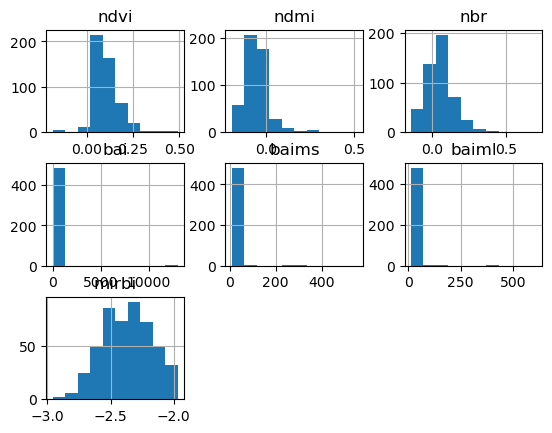

In [64]:
random_points[np.isfinite(random_points[['ndvi', 'ndmi', 'nbr', 'bai', 'baims', 'baiml', 'mirbi']])][['ndvi', 'ndmi', 'nbr', 'bai', 'baims', 'baiml', 'mirbi']].hist()
plt.show()

In [170]:
random_points.to_csv('./145044_20100428_indices/random_points_indices_data.csv')

In [167]:
random_points['class1'].value_counts()

11    149
5     111
1      56
13     50
4      43
15     35
2      22
16     15
17     10
8       9
Name: class1, dtype: int64